This notebook contains an introduction to some important components in analysis of neutrino data at the IceCube experiment, focusing on the recent discovery of a high-energy neutrino flux from the active galaxy NGC 1068. (You will re-discover this yourself!) There are more details in the slides that come along with this.

The emphasis here is on understanding the concepts of both the physics and analysis, rather than computational efficiency. For example, I have often explicitly written out loops that could be done implicitly, and I have made a few approximations to the pdf's to make the analysis run faster.

If you have questions, comments, etc. about this notebook or anything please feel free to contact me! Jeff Hyde jhyde1@swarthmore.edu

If you have not previously used a Jupyter notebook, you can run each cell by "Shift+Enter' or 'Shift+Return' while your cursor is in that cell. If you go back and change something from earlier in the code, you should then re-run any later cells that depend on that.

In [2]:
# Import some useful things:

import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import scipy.stats as stats
from scipy.stats import chi2
from scipy import integrate
from scipy.integrate import quad

# Things to adjust plots:

import matplotlib.cm as cm
font = {'size' : 12}
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12) 
mpl.rc('font', **font)

from palettable.cubehelix import Cubehelix
cx = Cubehelix.make(start=0.3, rotation=-0.5, n=16, reverse=True, gamma=1.0,
                     max_light=1.0, max_sat=0.5, min_sat=1.4).get_mpl_colormap()
from matplotlib.colors import LinearSegmentedColormap
llh_map = LinearSegmentedColormap.from_list("NewPSMap",["#3972A0", "w"], gamma=0.7)

Neutrino Detection: from flux to signal

A typical form for incident flux, predicted by models of high-energy particle acceleration, is $\Phi(E) = \Phi_0 \left(\frac{E}{E_0}\right)^{-\gamma}$, where $E_0$ is a reference scale (often 1 TeV or 100 TeV) and the normalization $\Phi_0$ determines how intense the incident flux is.

The *spectral index* $\gamma$ is a dimensionless number, while $\Phi_0$ is often given as $cm^{-2} s^{-1} GeV^{-1}$. The first two pieces represent the idea of flux as rate of particles passing through an area, while the last part reflects that this is an energy spectrum: the overall flux (of neutrinos at all energies) would be $\Phi_{\rm total} = \int \Phi(E) dE$. For this reason, some references will use the notation $d\Phi/dE$ instead of $\Phi(E)$.

For example, some neutrino fluxes determined by IceCube:

    Diffuse high-energy (>60 TeV): $\Phi_0 = 1.8 x 10^{-17}$ GeV$^{-1}$ cm$^{-2}$ s$^{-1}$ , $\gamma = 2.37$
    
    NGC 1068: $\Phi_0 = 8.8 \times 10^{-11}$ GeV$^{-1}$ cm$^{-2}$ s$^{-1}$, $\gamma = 3.2$

This is all nice, but the flux is never directly seen - neutrinos are famous for passing through matter without interacting much! So how do we determine the flux?

/var/folders/dr/tnb6gyns3kl9xhswdbqkpm_00000gn/T/ipykernel_33827/60711031.py:4: DeprecationWarning: Please import `interp1d` from the `scipy.interpolate` namespace; the `scipy.interpolate.interpolate` namespace is deprecated and will be removed in SciPy 2.0.0.
  aeff_spline = pickle.load(ifile)


Text(0, 0.5, 'cm$^2$')

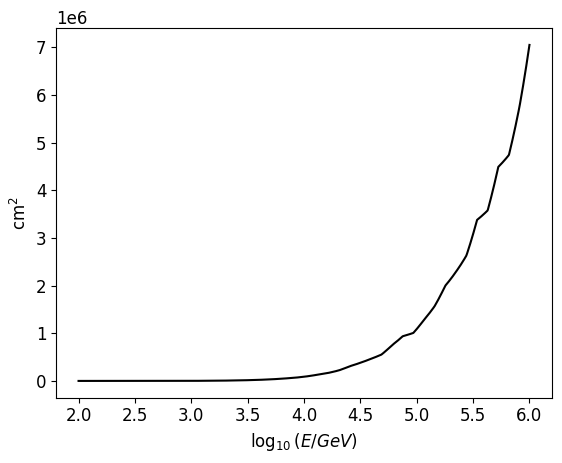

In [3]:
# effective area spline for IceCube track events in the data set we'll use.
# Takes energy (GeV) as argument, returns A_eff in cm^2
with open('./aeff_spline.pkl', 'rb') as ifile:
    aeff_spline = pickle.load(ifile)

# Example:
logEs = np.linspace(2,6,1000)
plt.plot(logEs,aeff_spline(10**logEs),'k')
plt.xlabel(r'$\log_{10}(E / GeV)$')
plt.ylabel(r'cm$^2$')

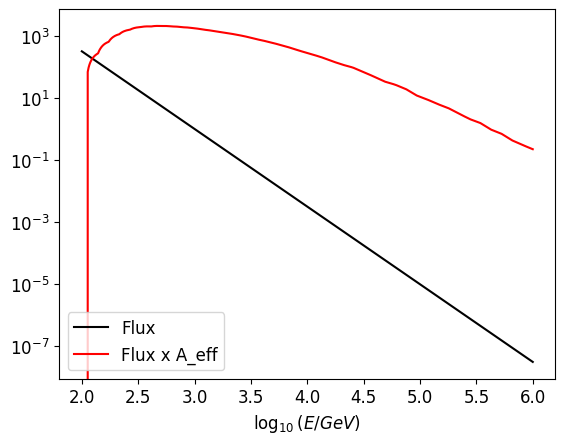

In [4]:
# function to compute power-law spectrum for incident flux

E0 = 1000 # 1000 GeV = 1 TeV reference energy
def flux(energy,index,norm):
    return norm * (energy/E0)**(-index)

FluxNormNGC1068 = 8.8 * 10**-11

# For example...
plt.plot(logEs,flux(10**logEs,2.5,1),'k',label='Flux')
plt.plot(logEs,aeff_spline(10**logEs)*flux(10**logEs,2.5,1),'r',label='Flux x A_eff')
plt.yscale('log')
plt.xlabel(r'$\log_{10}(E / GeV)$')
plt.legend(loc = 'lower left')

In [5]:
# The NGC 1068 data set represents about 3186 days of live time.
# The relationship between the flux and the number detected (within the range
# 10^2 to 10^6 GeV) is found by integration:

T_sec = 3186 * 24 * 60 * 60
N_signal = quad(lambda x: T_sec * aeff_spline(10**x)*flux(10**x,3.2,FluxNormNGC1068),2,6)[0]
print(N_signal)

79.11318601457734


/var/folders/dr/tnb6gyns3kl9xhswdbqkpm_00000gn/T/ipykernel_33827/455541131.py:6: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  N_signal = quad(lambda x: T_sec * aeff_spline(10**x)*flux(10**x,3.2,FluxNormNGC1068),2,6)[0]


How many neutrinos from NGC 1068, with energies between $10^3$ and $10^5$ GeV, pass through the IceCube detector every year? How many of these interact and are detected?

Now, before looking at NGC 1068 data, we'll take a moment to investigate likelihood functions. In short, the likelihood function is the probability of observing the data, given a particular model. There is an example below.

Let's say we have some data (e.g. positions of a particle) which we generically expect to be uniformly distributed over some range (background). We also suspect that there may be a signal which is a gaussian centered at x = 0, with width $\sigma = 3$.

Quantitatively, for data in the range [-10,10], the background probability density function (pdf) is $f_{\rm background} = 1 / (10 - (-10)) = 1/20 = 0.05$, and the signal pdf is $f_{\rm signal}(x) = \exp(x^2 / (2\sigma^2)) / \sqrt{2\pi\sigma^2}$.

The likelihood function is
$\mathcal{L} = \prod_{i=1}^N n_s f_{\rm signal}(x) + (1 - n_s/N)f_{\rm background}$.

For convenience, we often look at the *log* of the likelihood function - this makes very large/small numbers more manageable, and turns the above product into a sum.

Now we will start looking at IceCube data, focusing on their recent discovery of neutrino emission from the nearby active galaxy NGC 1068. For clarity and time reasons, I have taken a subset of the data and simplified some things. This code is written to help you understand what goes into the analysis, not to maximize efficiency and/or accuracy. However, you *are* directly using the IceCube data to discover neutrino emission from NGC 1068 for yourself, with numbers only slightly off (and within the quoted error bars).

Paper Reference: https://www.science.org/doi/10.1126/science.abg3395

IceCube Data Releases: https://icecube.wisc.edu/science/data-releases/

In [6]:
# Load my spline interpolations of the pdfs relevant to NGC 1068.
# These have been simplified a little to speed things up a lot with 
# only a modest loss of accuracy. For example, I have averaged over
# the spatial pdf's weak dependence on spectral index.


with open('energy-pdf-track-ngc1068.pkl', 'rb') as f:
    energy_pdf = pickle.load(f)

with open('spatial-pdf-track-ngc1068.pkl', 'rb') as f:
    spatial_pdf = pickle.load(f)

with open('background-pdf-track-ngc1068.pkl', 'rb') as f:
    bg_pdf = pickle.load(f)

# These take arguments:
# energy pdf (log10(energy/GeV), spectral index)
# spatial pdf (log10(spatial separation), log10(angular error))
# background pdf (log10(energy/GeV))

/var/folders/dr/tnb6gyns3kl9xhswdbqkpm_00000gn/T/ipykernel_33827/2982156355.py:8: DeprecationWarning: Please import `interp2d` from the `scipy.interpolate` namespace; the `scipy.interpolate.interpolate` namespace is deprecated and will be removed in SciPy 2.0.0.
  energy_pdf = pickle.load(f)
/var/folders/dr/tnb6gyns3kl9xhswdbqkpm_00000gn/T/ipykernel_33827/2982156355.py:11: DeprecationWarning: Please import `interp2d` from the `scipy.interpolate` namespace; the `scipy.interpolate.interpolate` namespace is deprecated and will be removed in SciPy 2.0.0.
  spatial_pdf = pickle.load(f)
/var/folders/dr/tnb6gyns3kl9xhswdbqkpm_00000gn/T/ipykernel_33827/2982156355.py:14: DeprecationWarning: Please import `interp1d` from the `scipy.interpolate` namespace; the `scipy.interpolate.interpolate` namespace is deprecated and will be removed in SciPy 2.0.0.
  bg_pdf = pickle.load(f)


In [7]:
# NGC 1068

src_ra = 40.667
src_dec = -0.0069

# load event sample

samples_full = pd.read_csv('event_list_ic.txt')

#print(samples_full)

In [8]:
# For later, these will be useful:
samples_full['sin_dec'] = np.sin(samples_full['dec'])
samples_full['log10_ang_err'] = np.log10(samples_full['angErr'])
# Notice that in the line above, log10 takes an array as argument, performs
# the operation on every element, and returns an array holding the results.

# define an angular distance, (later we'll call it psi):
def angular_distance(ra_1, dec_1, ra_2, dec_2):
        '''Compute the great circle distance between two events'''
        '''All coordinates must be given in radians'''
        delta_dec = np.abs(dec_1 - dec_2)
        delta_ra = np.abs(ra_1 - ra_2)
        x = (np.sin(delta_dec / 2.))**2. + np.cos(dec_1) *\
            np.cos(dec_2) * (np.sin(delta_ra / 2.))**2.
        return 2. * np.arcsin(np.sqrt(x))

# create array giving angular separation between source (NGC 1068) and each event
psi = angular_distance(samples_full['ra'],samples_full['dec'], np.radians(src_ra), np.radians(src_dec))
samples_full['psi'] = psi

# It'll be useful to also have log10(psi) and sin(psi)
samples_full['log10_psi']= np.log10(samples_full['psi'])
samples_full['sin_psi'] = np.sin(samples_full['psi'])

# If we want, we can sort the list according to any attribute...
samples_full.sort_values('logE', inplace=True)
#print(samples_full)
# inplace=True changes the list itself (vs. returning a newly sorted list w/ old left unchanged)


# now select all events within a given radius of source:
box_size=15 # degrees (up to 15)
samples = samples_full.loc[samples_full['psi'] < np.radians(box_size)].copy()

# Some numbers to use later:

N = 665293 # Total number of all events in the all-sky sample.
Nprime = len(samples) # Number of events within the box size
DeltaN = N - Nprime


In [9]:
# Evaluate each pdf on all sample data,
# return array with list of these...

# energy pdf (log10(energy/GeV), spectral index)
# spatial pdf (log10(spatial separation), log10(angular error))
# background pdf (log10(energy/GeV))

def eval_energy_pdf(gamma):
    epdf_array = []
    for i in range(0,len(samples)):
        log_energy = samples['logE'][i]
        epdf_array.append(energy_pdf(log_energy,gamma))
    return epdf_array

def eval_spatial_pdf():
    spdf_array = []
    for i in range(0,len(samples)):
        log10_psi = samples['log10_psi'][i]
        log10_ang_err = samples['log10_ang_err'][i]
        spatial_norm = np.log(10) * samples['psi'][i] * samples['sin_psi'][i]
        spdf_array.append(spatial_pdf(log10_psi,log10_ang_err)/spatial_norm)
    return spdf_array

def eval_background_pdf():
    bpdf_array = []
    for i in range(0,len(samples)):
        log_energy = samples['logE'][i]
        bpdf_array.append(bg_pdf(log_energy))
    return bpdf_array


The likelihood function used to examine point source data is:

$\mathcal{L} = \prod_{i=1}^N \left(\frac{n_s}{N} f_{\rm signal}(data | \gamma, n_s) + \left(1 - \frac{n_s}{N}\right)f_{\rm background}(data)\right)$

where $n_s$ and $n_b$ are the number of signal and background events, $N$ is the total number of events, $f_{\rm signal} = f_{\rm spatial} \times f_{\rm energy}$.

Null hypothesis: sample consists of only background events.

Test hypothesis: sample consists of $n_s$ signal events and $n_b = N - n_s$ background events.

Test statistic: $\lambda = 2 \log(\mathcal{L}_{\rm test} / \mathcal{L}_{\rm null})$

In [10]:
# Likelihood ratio test - function from IceCube, modified to work here

# evaluate background pdf
# (independent of model parameters - do only once for better efficiency)
bpdfs = eval_background_pdf()

# evaluate spatial pdf (we've approximated as independent of model parameters)
spdfs = eval_spatial_pdf()

def logl(ns, gamma):

    # evaluate energy pdf
    epdfs = eval_energy_pdf(gamma)
    
    # ratio of signal and background pdf for single events
    sb_ratio = []
    for i in range(0,len(samples)):
        sb_ratio.append(spdfs[i] * epdfs[i] / bpdfs[i])
    
    # point source likelihood
    lh_vals = []
    for i in range(0,len(samples)):
        lh = ns/N * (sb_ratio[i] - 1.) + 1.
        lh_vals.append(lh)
    
    # sum contribution from all selected events
    logl = np.sum(np.log(lh_vals))
    
    # contribution from events at large distance with S~0
    logl += DeltaN * np.log(1.-ns/N)
    
    return logl


/var/folders/dr/tnb6gyns3kl9xhswdbqkpm_00000gn/T/ipykernel_33827/952026786.py:21: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  spdf_array.append(spatial_pdf(log10_psi,log10_ang_err)/spatial_norm)


In [11]:
# Data: discover NGC 1068 result for yourself!


# possible values of spectral index (gamma), number of signal events (n_s)
NnsVals = 30
NgammaVals = 20
nsmin = 20
nsmax = 140
gammin = 2.5
gammax = 4.0

nss = np.linspace(nsmin,nsmax,NnsVals)
gammas = np.linspace(gammin,gammax,NgammaVals)

# now look at all combinations of these values, calculate log-likelihood ratio
# for each, keep track of max. value

MaxGammaHere = 0
MaxNSHere = 0
MaxLLH = -1.e20
LLVs = np.zeros([NnsVals,NgammaVals])
for k in range(0,NnsVals):
    print(k,'/',NnsVals)
    for l in range(0,NgammaVals):
        ThisLLV = 2*logl(nss[k], gammas[l]) 
        if ThisLLV > MaxLLH:
            MaxGammaHere = gammas[l]
            MaxNSHere = nss[k]
            MaxLLH = ThisLLV
        LLVs[k][l] = ThisLLV

print('nsmax =',MaxNSHere,'Gamma Max =',MaxGammaHere)


0 / 30


/var/folders/dr/tnb6gyns3kl9xhswdbqkpm_00000gn/T/ipykernel_33827/952026786.py:12: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  epdf_array.append(energy_pdf(log_energy,gamma))


1 / 30
2 / 30
3 / 30
4 / 30
5 / 30
6 / 30
7 / 30
8 / 30
9 / 30
10 / 30
11 / 30
12 / 30
13 / 30
14 / 30
15 / 30
16 / 30
17 / 30
18 / 30
19 / 30
20 / 30
21 / 30
22 / 30
23 / 30
24 / 30
25 / 30
26 / 30
27 / 30
28 / 30
29 / 30
nsmax = 65.51724137931035 Gamma Max = 3.052631578947368


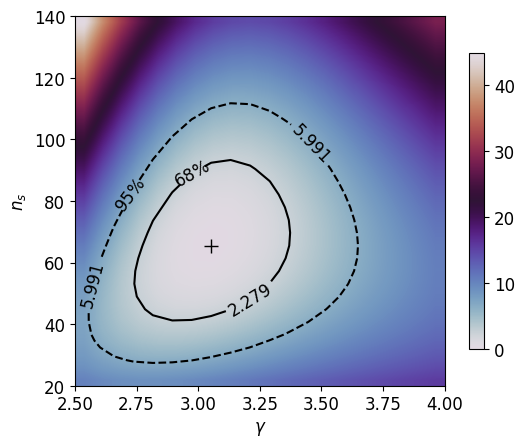

In [12]:
# Plot results and confidence regions

DeltaLLVs = MaxLLH - LLVs

X, Y = np.meshgrid(gammas,nss)
fig, ax = plt.subplots()

# contours at 68%, 95%, 99% C.L.
im = ax.imshow(DeltaLLVs, interpolation='bilinear', origin='lower', cmap=cm.twilight, extent=(gammin,gammax,nsmin,nsmax))
ConPlot = ax.contour(gammas,nss,DeltaLLVs, [chi2.isf(0.32,2),chi2.isf(0.05,2)], colors=['k','k'],
                     linestyles=['-', '--', ':','-'], extent=(gammin,gammax,nsmin,nsmax))

plt.clabel(ConPlot, fmt={chi2.isf(0.32, 2): r'$68\%$',
                         chi2.isf(0.05, 2): r'$95\%$'},
           inline=1, fontsize=12, inline_spacing=0)

CB = fig.colorbar(im, shrink=0.8)

plt.plot(MaxGammaHere,MaxNSHere,'k+', markersize=10)

ax.set_aspect((gammax-gammin)/(nsmax-nsmin))
ax.clabel(ConPlot, inline=True, fontsize=12)
ax.set_xlabel(r'$\gamma$', fontsize=12)
ax.set_ylabel(r'$n_s$', fontsize=12)
plt.show()

Some questions to consider:

- Find the twenty events which contributed most to the likelihood at the best-fit point. Is there a noticeable trend to how they are distributed, in comparison to the overall data sample? (For instance, we might guess that they tend to have smaller angular uncertainty... but is this the case? What about other quantities?)


- What do you think are some limitations of this analysis? Could these be addressed by small tweaks to the methodology, or major changes?


- If you were looking for evidence of neutrinos scattering *before* reaching the detector, what would you change about this? (See https://arxiv.org/abs/2307.02361 for more details :) )